In [33]:
import imageio
import cv2
import subprocess
import librosa
import librosa.display
import soundfile as sf
import os
import torch
from torchvision import transforms
from inference.Inferencer import Inferencer
from models.PasticheModel import PasticheModel
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from PIL import Image

In [6]:
# setup style transfer model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_styles = 16
image_size =512
model_save_dir = "model/pastichemodel-FINAL.pth"
pastichemodel = PasticheModel(num_styles)
inference = Inferencer(pastichemodel,device,image_size)
inference.load_model_weights(model_save_dir)   

In [53]:
# function to transform image
def get_transformation(im, pos, strength=1):
    #im = reference frame
    #pos is float from 0 to 1 that interps between the images
    #strength float 0 to 1 that sets blending between ref and transformed image. strength 1 is 100% transformed
    pos = pos - int(pos)
    style_1 = int(pos*15)
    style_2 = style_1 + 1 if style_1 <= 15 else 0
    blend = pos*15 - style_1
    return inference.eval_image(im, style_1, style_2, 1-blend)

In [121]:
# get masks
josh = mask[:,:,0] > 0
josh = cv2.resize(np.array(josh, dtype='uint8'), dsize=(512, 684), interpolation=cv2.INTER_NEAREST)
josh = np.rollaxis(np.array([josh,josh,josh]), 0,3)

ana = mask[:,:,1] > 0
ana = cv2.resize(np.array(ana, dtype='uint8'), dsize=(512, 684), interpolation=cv2.INTER_NEAREST)
ana = np.rollaxis(np.array([ana,ana,ana]), 0,3)

ever = mask[:,:,2] > 0
ever = cv2.resize(np.array(ever, dtype='uint8'), dsize=(512, 684), interpolation=cv2.INTER_NEAREST)
ever = np.rollaxis(np.array([ever,ever,ever]), 0,3)

back = (josh + ana + ever) < 1

In [123]:
def get_multi_transformations(im, pos, strength=1):
    im1 = get_transformation(im, pos[0], strength=1)
    im2 = get_transformation(im, pos[1], strength=1)
    im3 = get_transformation(im, pos[2], strength=1)
    im4 = get_transformation(im, pos[3], strength=1)
    return im1 * josh + im2 * ana + im3*ever + im4*back

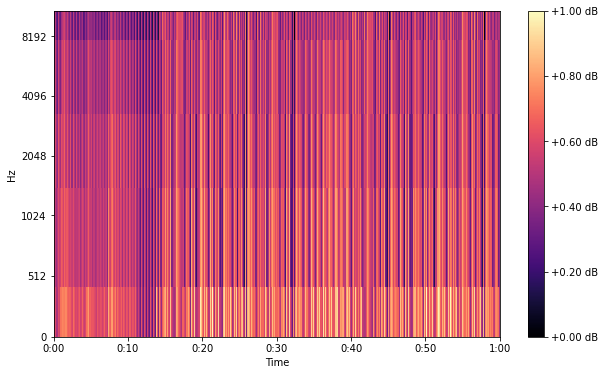

In [140]:
# load audio
audio_data = 'audio/disclosure.wav'
z, sr = librosa.load(audio_data, offset = 50., duration = 60)
out_audio_path = 'output_video/test_audio_only.wav'
sf.write(out_audio_path, z, sr)
z_harmonic, z_percussive = librosa.effects.hpss(z)
hop_length = 735
Nfft = 2048
n_mels = 5
mel_spect = librosa.feature.melspectrogram(z_percussive, sr=sr, n_fft=Nfft, hop_length=hop_length, n_mels=n_mels)
log_mel_spect= librosa.power_to_db(mel_spect)
norm_mel_spect = (log_mel_spect - log_mel_spect.min()) / (log_mel_spect.max() - log_mel_spect.min())
# Plot the Mel Spectrogram
def mel_grams():
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(norm_mel_spect,
                             x_axis="time",
                             y_axis="mel",
                             sr=sr,
                            hop_length=hop_length)
    plt.colorbar(format="%+2.2f dB")
    plt.show()
mel_grams()

In [141]:
Audio(data=z, rate=sr)

In [68]:
print(norm_mel_spect.shape)

(5, 901)


In [70]:
# write video no audio
ref_image_path = "input_photos/you_me_and_ever.jpg"
ref_im = Image.open(ref_image_path).convert('RGB')
out_video_path = 'output_video/test_video_only.avi'
writer = imageio.get_writer(out_video_path, fps=30)
for i, bass in enumerate(norm_mel_spect[0, :-1]):
    if i%30 == 0:
        print(i/30)
    pos = i/1000 + bass/8
    im = get_transformation(ref_im, pos, strength=1)
    writer.append_data(np.array(im))
writer.close()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (512, 684) to (512, 688) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0


In [142]:
# write video no audio
ref_image_path = "input_photos/you_me_and_ever.jpg"
ref_im = Image.open(ref_image_path).convert('RGB')
out_video_path = 'output_video/test_video_only.avi'
writer = imageio.get_writer(out_video_path, fps=30)
for i, (sbass, bass, med, treb, utreb) in enumerate(norm_mel_spect.T):
    if i%30 == 0:
        print(i/30)
    pos1 = i/1000 + sbass/8
    pos2 = 0.25 + i/1000 + bass/8
    pos3 = 0.5 + i/1000 + med/8
    pos4 = 0.75 + i/1000 + treb/8
    pos = [pos1, pos2, pos3, pos4]
    im = get_multi_transformations(ref_im, pos, strength=1)
    writer.append_data(np.array(im))
writer.close()

0.0


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (512, 684) to (512, 688) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
